In [1]:
# The load_path function loads the .jpg image and converts it to a numpy array. 
# It also extracts the image label from path and places it into file_array
import numpy as np
import os
from PIL import Image
import time
import glob
def load_data(paths):
    
    X = []
    file_array = []
    label_array = []
  
    # Images are resized because they range from 720-924 and 1192-1280 Making it difficult to use in models
    # and neural networks
    # Most 'common' original image size
    # The 'im.resize' switches these dimensions. That is why they are backwards here.
    size = 1280, 720
    
    print('..loading images')
    start = time.time()
    
    # if loading 'training set' also extract label from file
        
    for path in glob.glob(paths):

        try:
            # load image and convert to np array
            im = Image.open(path)
            im = im.resize((size[0], size[1]))
            im = np.asarray(im)
            X.append(im)

            # extract file name EX: img_00003.jpg
            base = os.path.basename(path)
            file_array.append(base)

            if 'train' in paths:
                # extract fish label (ALB, BET, DOL, LAG, NoF, OTEHR, SHARK, YFT)
                directory = os.path.split(path)[0]
                label_array.append(os.path.split(directory)[1])

        except IOError:
            print( "cannot load or resize image for %s" % path)


    print('time elapsed: ' + str(time.time() - start))

    if 'train' in paths:
        return X, file_array, label_array

    else:
        return X, file_array


In [2]:
X, file_array, label_array = load_data('F:/Kaggle/The Nature Conservancy/train/train/*/*')

..loading images
time elapsed: 71.8870000839


In [834]:
# extracts list of 320x320 sub-images from image X
def create_windows_from_image(X):
    #window_height = 32
    #window_width = 128
    #window_height = 160
    #window_width = 380
    #window_height = 96
    #window_width = 192
    window_height = 256
    window_width = 256
    window_slide = 30
    window_horizontal_idx = 0
    window_vertical_idx = 0
    window_array = []
    horizontal_num_windows = 0
    vertical_num_windows = 0

    #slide horizontal then vertical
    while (window_vertical_idx+window_height) <= X.shape[1]:


        while (window_horizontal_idx+window_width) <= X.shape[2]:
            X_temp = X[0,window_vertical_idx:window_vertical_idx+window_height,
                             window_horizontal_idx:window_horizontal_idx+window_width,:]
            window_array.append(X_temp)
            window_horizontal_idx += window_slide
            horizontal_num_windows += 1
        window_horizontal_idx = 0
        horizontal_num_windows = 0
        window_vertical_idx += window_slide
        vertical_num_windows += 1
    
    return window_array

In [4]:
# reshape X for cnn (samples, channels, rows, columns)
# where X is originally (samples, rows, columns, channels)
def reshape_for_cnn(X):
    
    X_cnn = np.zeros([X.shape[0], X.shape[3], X.shape[1], X.shape[2]])
    for samples in xrange(X.shape[0]):
        for channels in xrange(X.shape[3]):
            X_cnn[samples,channels,:,:] = X[samples,:,:,channels]
            
    return X_cnn

In [5]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

In [6]:
from keras.models import load_model
CNN_model = load_model('F:/Kaggle/The Nature Conservancy/cnn_models/cnn_cifar100_with_fish_table_outdoor_people_2.h5')

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5103)


In [211]:
CNN_model2 = load_model('F:/Kaggle/The Nature Conservancy/cnn_models/cnn_cifar100_with_fish_aquaMammal_foodContainers_table_outdoor_people.h5')

In [7]:
from skimage.measure import block_reduce
#temp_reduce = block_reduce(temp, block_size=(10, 11, 1), func=np.mean).astype(int)

In [8]:
X_train = np.asarray(X)

In [931]:
# 67, 678, 680 is difficult sample
SAMPLE = 10
X_windows = create_windows_from_image(X_train[SAMPLE:SAMPLE+1,:,:,:])

X_windows_reduced = []
for sample in xrange(len(X_windows)):
    #temp_reduce = block_reduce(X_windows[sample], block_size=(2, 4, 1), func=np.mean).astype(int)# for 32x128 window
    temp_reduce = block_reduce(X_windows[sample], block_size=(8, 8, 1), func=np.mean).astype(int)
    X_windows_reduced.append(temp_reduce)
    
X_windows_reduced[0].shape

(32L, 32L, 3L)

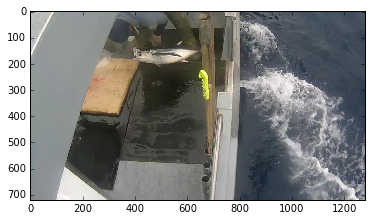

In [930]:
imshow(X_train[10,:,:,:])

In [600]:
256/16

16

In [601]:
X_windows_reduced[0].shape

(16L, 32L, 3L)

In [602]:
# extend image 'naturally
X_windows_filled = []

if X_windows_reduced[0].shape[0] < X_windows_reduced[0].shape[1]:

    
    #add padding to  top and bottom 
    for sample in xrange(len(X_windows_reduced)):
        
        temp_top = X_windows_reduced[sample][0,:,:]
        temp_bot = X_windows_reduced[sample][-1,:,:]


        blank_top = np.zeros([8,32,3])
        blank_bot = np.zeros([8,32,3])

        for row in xrange(8):
            blank_top[row,:,:] = temp_top
            blank_bot[row,:,:] = temp_bot


        temp_with_blank = np.append(blank_top, X_windows_reduced[sample], axis=0)
        temp_with_blank = np.append(temp_with_blank, blank_bot, axis=0)
    
        X_windows_filled.append(temp_with_blank)
    
# add padding to left and right
else:
    for sample in xrange(len(X_windows_reduced)):
        
        temp_left = X_windows_reduced[sample][:,0,:]
        temp_right = X_windows_reduced[sample][:,-1,:]

        blank_left = np.zeros([32,8,3])
        blank_right = np.zeros([32,8,3])

        for row in xrange(8):
            blank_left[:,row,:] = temp_left
            blank_right[:,row,:] = temp_right

        temp_with_blank = np.append(blank_left, X_windows_reduced[sample], axis=1)
        temp_with_blank = np.append(temp_with_blank, blank_right, axis=1)    
        
        
        X_windows_filled.append(temp_with_blank)

In [603]:
X_windows_filled[0].shape

(32L, 32L, 3L)

In [932]:
X_cnn = np.asarray(X_windows_reduced)
X_cnn = reshape_for_cnn(X_cnn)
X_cnn /= 255.0

In [933]:
predictions = CNN_model2.predict(X_cnn)

In [934]:
predict_fish_aqua_sum = np.sum(predictions[:,0:2], axis=1)
predict_fish_aqua_dif = np.absolute(predictions[:,0] - predictions[:,1])

predict_fish_aqua_sum = np.reshape(predict_fish_aqua_sum, [len(predict_fish_aqua_sum), 1])
predict_fish_aqua_dif = np.reshape(predict_fish_aqua_dif, [len(predict_fish_aqua_dif), 1])

predictions2 = np.append(predict_fish_aqua_sum, predict_fish_aqua_dif, axis=1)

In [935]:
good_windows = (np.where((predictions2[:,0] >.8) & (predictions2[:,1] < .1)))

In [936]:
good_windows

(array([  7,   8,  13, 433, 468, 469], dtype=int64),)

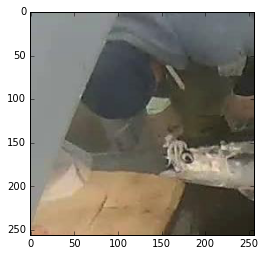

In [940]:
imshow(X_windows[8])

# Hough Circle Transform

In [920]:
import cv2
import numpy as np

#img = cv2.imread('opencv_logo.png',0)
#img = cv2.medianBlur(img,5)
img = X_windows[504]
img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cimg = cv2.cvtColor(img_bw,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img_bw,cv2.cv.CV_HOUGH_GRADIENT,1,20,
                            param1=40,param2=40,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

cv2.imshow('detected circles',cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [773]:
CNN_model2.predict(X_cnn[375:376,:,:,:])

array([[ 0.49895173,  0.12447186,  0.00785687,  0.00500157,  0.10175501,
         0.2619631 ]], dtype=float32)

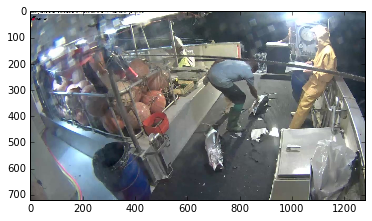

In [923]:
imshow(X_train[SAMPLE,:,:,:])

In [330]:
X_cnn.shape

(700L, 3L, 32L, 32L)

In [386]:
CNN_model2.predict(X_cnn[567:568,:,:,:])

array([[ 0.12738229,  0.04421962,  0.72843856,  0.00172846,  0.0023804 ,
         0.09585071]], dtype=float32)

In [331]:
predict_fish_aqua = np.sum(predictions[:,0:2], axis=1)

In [332]:
predict_fish_aqua.shape

(700L,)

In [333]:
good_predictions2 = np.where(predict_fish_aqua > .99)

In [334]:
good_predictions2

(array([424, 425], dtype=int64),)

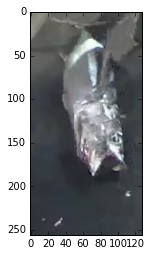

In [384]:
imshow(X_windows[567])

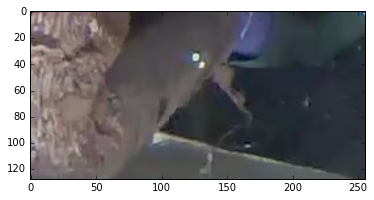

In [301]:
imshow(X_windows[good_predictions[0][3]])

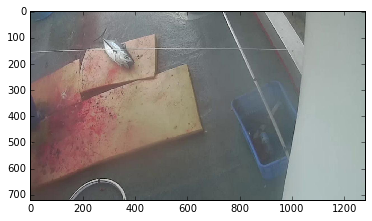

In [11]:
imshow(X_train[SAMPLE,:,:,:])

In [9]:
import cv2

In [398]:
img = X_train[SAMPLE,:,:,:]

rows,cols, channels = img.shape
 
M = cv2.getRotationMatrix2D((cols/2,rows/2),60,1)
dst = cv2.warpAffine(img,M,(cols,rows))

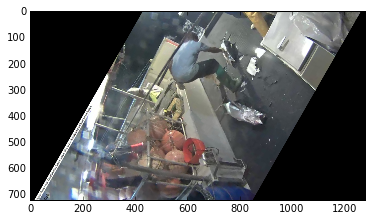

In [399]:
imshow(dst)

In [195]:
dst.shape

(720L, 1280L, 3L)

In [402]:
dst = np.reshape(dst, [1, 720, 1280, 3])
X_windows = create_windows_from_image(dst)

X_windows_reduced = []
for sample in xrange(len(X_windows)):
    #temp_reduce = block_reduce(X_windows[sample], block_size=(2, 4, 1), func=np.mean).astype(int)# for 32x128 window
    #temp_reduce = block_reduce(X_windows[sample], block_size=(10, 12, 1), func=np.mean).astype(int)
    
    #window dimensions must be divided by block_size dimensions
    
    temp_reduce = block_reduce(X_windows[sample], block_size=(8, 8, 1), func=np.mean).astype(int)
    X_windows_reduced.append(temp_reduce)
    
X_windows_reduced[0].shape

(16L, 32L, 3L)

In [548]:
6*32

192

In [403]:
# extend image 'naturally
X_windows_filled = []

if X_windows_reduced[0].shape[0] < X_windows_reduced[0].shape[1]:

    
    #add padding to  top and bottom 
    for sample in xrange(len(X_windows_reduced)):
        
        temp_top = X_windows_reduced[sample][0,:,:]
        temp_bot = X_windows_reduced[sample][-1,:,:]


        blank_top = np.zeros([8,32,3])
        blank_bot = np.zeros([8,32,3])

        for row in xrange(8):
            blank_top[row,:,:] = temp_top
            blank_bot[row,:,:] = temp_bot


        temp_with_blank = np.append(blank_top, X_windows_reduced[sample], axis=0)
        temp_with_blank = np.append(temp_with_blank, blank_bot, axis=0)
    
        X_windows_filled.append(temp_with_blank)
    
# add padding to left and right
else:
    for sample in xrange(len(X_windows_reduced)):
        
        temp_left = X_windows_reduced[sample][:,0,:]
        temp_right = X_windows_reduced[sample][:,-1,:]

        blank_left = np.zeros([32,8,3])
        blank_right = np.zeros([32,8,3])

        for row in xrange(8):
            blank_left[:,row,:] = temp_left
            blank_right[:,row,:] = temp_right

        temp_with_blank = np.append(blank_left, X_windows_reduced[sample], axis=1)
        temp_with_blank = np.append(temp_with_blank, blank_right, axis=1)    
        
        
        X_windows_filled.append(temp_with_blank)

In [99]:
temp_with_blank.shape

(32L, 32L, 3L)

In [467]:
X_cnn = np.asarray(X_windows_filled)
X_cnn = reshape_for_cnn(X_cnn)
X_cnn /= 255.0

predictions = CNN_model2.predict(X_cnn)

good_predictions = np.where(predictions[:,1] > .99)

good_predictions

(array([], dtype=int64),)

In [475]:
predict_fish_aqua_sum = np.sum(predictions[:,0:2], axis=1)
predict_fish_aqua_sum.shape

(700L,)

In [487]:
predict_fish_aqua_sum[:10]

array([ 0.18540011,  0.18540011,  0.18540011,  0.18540011,  0.15976708,
        0.1859104 ,  0.38278711,  0.73855734,  0.88290238,  0.915106  ], dtype=float32)

In [476]:
predict_fish_aqua_dif = np.absolute(predictions[:,0] - predictions[:,1])

In [477]:
predict_fish_aqua_dif.shape

(700L,)

In [478]:
predict_fish_aqua.shape

(700L, 1L)

In [492]:
predict_fish_aqua_sum = np.reshape(predict_fish_aqua_sum, [len(predict_fish_aqua_sum), 1])
predict_fish_aqua_dif = np.reshape(predict_fish_aqua_dif, [len(predict_fish_aqua_dif), 1])

predictions2 = np.append(predict_fish_aqua_sum, predict_fish_aqua_dif, axis=1)
predictions2.shape

(700L, 2L)

In [493]:
predictions2[20:30,0]

array([ 0.7187584 ,  0.53769249,  0.56184149,  0.40567666,  0.11098033,
        0.01434631,  0.12388185,  0.34989697,  0.20272003,  0.08644316], dtype=float32)

In [524]:
good_windows = (np.where((predictions2[:,0] >.9) & (predictions2[:,1] < .04)))

In [525]:
good_windows

(array([ 48, 411], dtype=int64),)

In [517]:
CNN_model2.predict(X_cnn[48:49,:,:,:])

array([[  4.77399021e-01,   4.42787796e-01,   2.74725142e-04,
          3.78793280e-04,   7.75761977e-02,   1.58346829e-03]], dtype=float32)

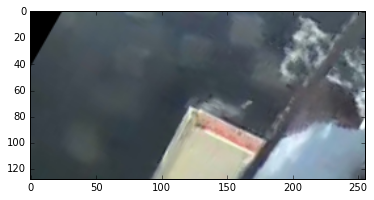

In [515]:
imshow(X_windows[48])

In [208]:
test = np.argmax(predictions, axis=1)

In [210]:
test

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2,
       1, 1, 2, 0, 0, 0], dtype=int64)

In [202]:
len(X_windows)

75

In [54]:
img.shape

(720L, 1280L, 3L)

In [654]:
img.shape

(92L, 192L, 3L)

In [205]:
predictions[:10,:]

array([[  3.73286784e-01,   2.10639685e-01,   7.45672435e-02,
          3.41506273e-01],
       [  1.66469559e-01,   7.51114309e-01,   3.53724905e-03,
          7.88788870e-02],
       [  5.81639558e-02,   9.37041998e-01,   2.79067346e-04,
          4.51501505e-03],
       [  5.46030283e-01,   2.63863117e-01,   5.91107318e-03,
          1.84195593e-01],
       [  9.99033868e-01,   1.44290228e-04,   4.19139513e-04,
          4.02706151e-04],
       [  9.99999881e-01,   5.64300695e-09,   4.54641391e-09,
          1.07594786e-07],
       [  9.99267042e-01,   1.52193883e-04,   8.35989837e-08,
          5.80652093e-04],
       [  9.99981523e-01,   8.45346312e-06,   1.39074814e-08,
          1.00773241e-05],
       [  8.48949432e-01,   1.36617152e-02,   1.13253444e-02,
          1.26063406e-01],
       [  4.20602381e-01,   8.77152532e-02,   4.69291657e-01,
          2.23907549e-02]], dtype=float32)

In [17]:
img = X_windows[487]
rows, cols, channels = img.shape
 
M_2 = cv2.getRotationMatrix2D((cols/2,rows/2),-90,1)
dst_2 = cv2.warpAffine(img,M_2,(192,192))

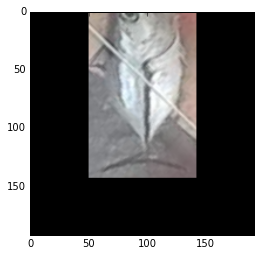

In [18]:
imshow(dst_2)

In [24]:
CNN_model.predict(X_cnn[487:488,:,:,:])

array([[ 0.05827329,  0.73715299,  0.19511662,  0.00945711]], dtype=float32)

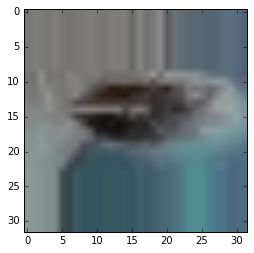

In [118]:
imshow(X_windows_filled[0])

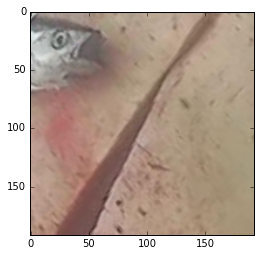

In [203]:
imshow(X_windows[good_predictions[0][0]])

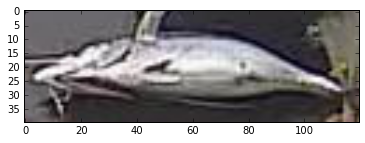

In [258]:
imshow(X_train[SAMPLE,300:340,720:840,:])

In [ ]:
temp = X_window_list[good_predictions[0][0]][30:40+150,150:150+360,:]
imshow(temp)
temp_reduce = block_reduce(temp, block_size=(10, 11, 1), func=np.mean).astype(int)
temp_reduce.shape
imshow(temp_reduce)

In [5]:
im = X[0]

In [7]:
im.shape

(720L, 1280L, 3L)

In [6]:
import numpy as np
import cv2

In [97]:
small_im = im[:150,:150,:]

In [148]:
im_new = np.zeros(im.shape)
im_new[:,:,2] = im[:,:,0]
im_new[:,:,1] = im[:,:,1]
im_new[:,:,0] = im[:,:,2]

In [149]:
a = np.asarray(im_new, dtype=uint8)

NameError: name 'uint8' is not defined

In [150]:
a = np.uint8(im_new)

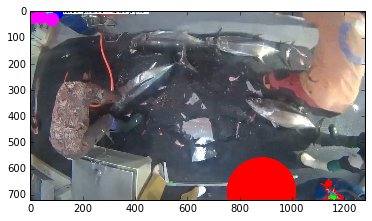

In [210]:
im = X[1]

In [211]:
im = X[1]
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
cnt = contours[-1]
cv2.drawContours(im, [cnt], -255, (255,0,255), 20)

cv2.imshow('Output', im)
cv2.waitKey(0)
cv2.destroyAllWindows()

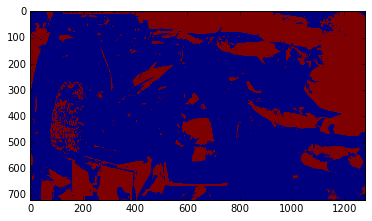

In [207]:
ret,thresh = cv2.threshold(imgray,127,255,0)
#contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
imshow(thresh)

In [183]:
len(contours)

1372

In [184]:
contours[0]

array([[[1241,  715]],

       [[1240,  716]],

       [[1239,  717]],

       [[1238,  717]],

       [[1238,  718]],

       [[1239,  718]],

       [[1240,  718]],

       [[1240,  717]],

       [[1241,  716]],

       [[1242,  716]],

       [[1242,  715]]])

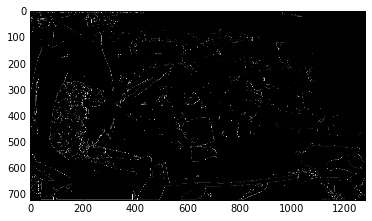

In [177]:
imshow(thresh, cmap='gray')

In [153]:
imgray

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   2,   2, ...,   2, 130,   0],
       [  0,   2,   1, ...,   1, 130,   0],
       ..., 
       [  0,   2,   1, ...,   1, 130,   0],
       [  0,   2,   2, ...,   2, 130,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [130]:
contours[-1]

array([[[21,  4]],

       [[22,  3]],

       [[23,  4]],

       [[22,  5]]])

In [123]:
cnt = contours[-1]
cv2.drawContours(imgray, [cnt], -255, (255,60,0), 5)

In [124]:
cv2.imshow('Output', imgray)
cv2.waitKey(0)
cv2.destroyAllWindows()

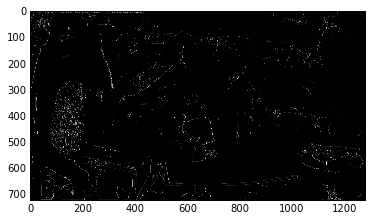

In [113]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

# imshow(np.asarray(X_train[0,100:400,300:600,:])) really good example (confidence of fish: 99%)
imshow(thresh, cmap='gray')

In [16]:
type(ret)

float

In [44]:
image = cv2.threshold(imgray,0,255,0)

In [45]:
image = np.reshape(np.asarray(image[1]), [720, 1280])

In [46]:
image.shape

(720L, 1280L)

In [125]:
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[-1]
cv2.drawContours(imgray, [cnt], 0, (55,55,0), 10)

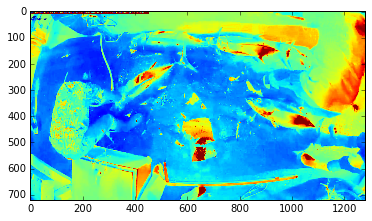

In [126]:
imshow(imgray)

In [107]:
len(contours)

1255

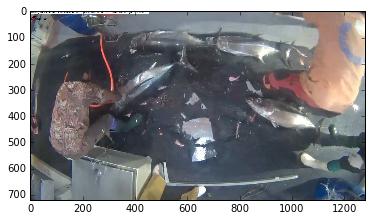

In [48]:
imshow(im)

# Canny Edge Detection

In [212]:
len(X)

3777

In [434]:
img = X[2000]

In [435]:
imgray.shape

(720L, 1280L)

In [439]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
#img = cv2.imread('messi5.jpg',0)
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#fourth argument: aperture size
#fifth argument: L2 gradient magnitude, default is false
edges = cv2.Canny(imgray,100,255,1)
 

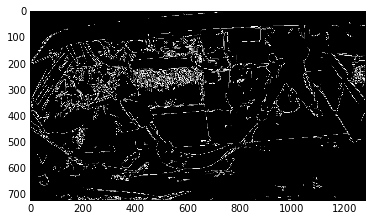

In [440]:
imshow(edges,cmap = 'gray')

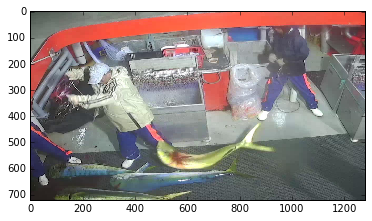

In [438]:
imshow(img)

In [294]:
im = Image.open('F:/Kaggle/The Nature Conservancy/train/train/ALB/img_00003.jpg')
im = np.asarray(im)

In [295]:
type(im)

numpy.ndarray

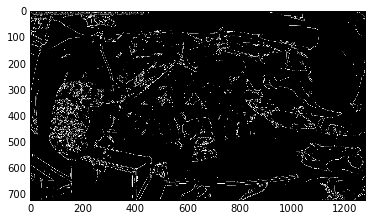

In [296]:
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(im,100,120)
 
imshow(edges,cmap = 'gray')

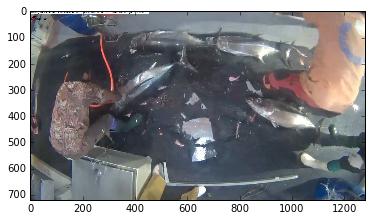

In [297]:
imshow(im)

# Template Matching

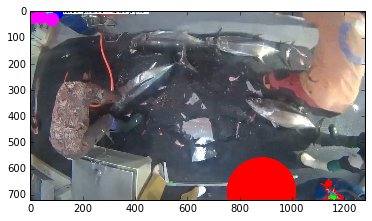

In [442]:
imshow(X[0])

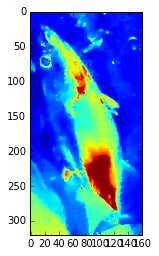

In [477]:
imshow(template)

In [463]:
template.T.shape

(320L, 160L)

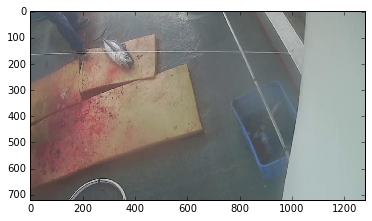

In [485]:
imshow(X[66])

In [488]:
img = cv2.cvtColor(X[80],cv2.COLOR_BGR2GRAY)
template = cv2.cvtColor(X[0][320:480,800:1120,:],cv2.COLOR_BGR2GRAY)
template = template.T
img2 = img.copy()

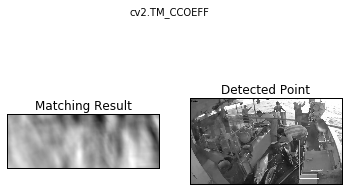

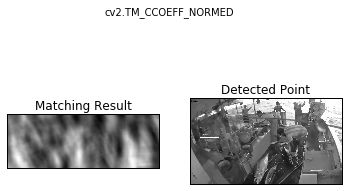

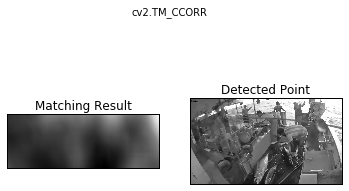

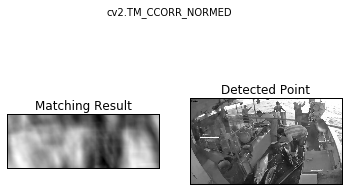

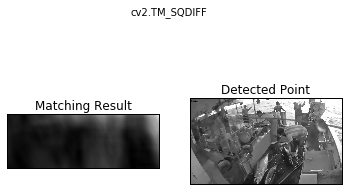

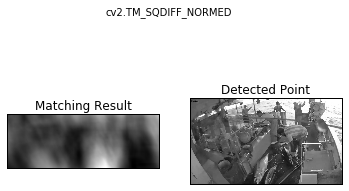

In [489]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#img = cv2.imread('messi5.jpg',0)
#img2 = img.copy()
#template = cv2.imread('template.jpg',0)
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

# matching template with returned windows from CNN1

In [493]:
from keras.models import load_model
CNN_model = load_model('F:/Kaggle/The Nature Conservancy/cnn_models/cnn_cifar100_with_fish_table_outdoor_people_2.h5')

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5103)


In [496]:
from skimage.measure import block_reduce

In [597]:
## SAMPLE 77 is a good example , good[0 and 10]
## 198 did well. size?
# 231, 237 should've been good. fish was too big?

In [759]:
SAMPLE = 237
X_window_list = create_windows_from_image(X_train[SAMPLE:SAMPLE+1,:,:,:])

X_reduced_window_list = []
for sample in xrange(len(X_window_list)):
    temp_window = block_reduce(X_window_list[sample], block_size=(16, 16, 1), func=np.mean).astype(int)
    X_reduced_window_list.append(temp_window)
    
X_reduced_array = np.asarray(X_reduced_window_list)

X_cnn = reshape_for_cnn(X_reduced_array)

fish_locations = CNN_model.predict(X_cnn)
good_predictions = np.where(fish_locations[:,0] > 0)

In [760]:
good_predictions

(array([40, 52], dtype=int64),)

In [761]:
#imshow(X_window_list[12])

In [766]:
50+128

178

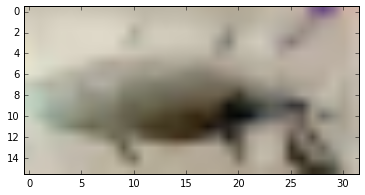

In [868]:
temp = X_window_list[good_predictions[0][0]][30:40+150,150:150+360,:]
imshow(temp)
temp_reduce = block_reduce(temp, block_size=(10, 11, 1), func=np.mean).astype(int)
temp_reduce.shape
imshow(temp_reduce)

# retain image ratio. fill in necessary dimension with zeros

In [808]:
np.max(temp_reduce)

254.0

In [811]:
temp_reduce.shape

(1L, 32L, 32L, 3L)

In [822]:
temp_reduce[0,0,1]

44

In [869]:
temp_reduce.shape

(16L, 32L, 3L)

In [870]:
# extent image 'naturally
blank = np.zeros([8,32,3])
temp_top = temp_reduce[0,:,:]
temp_bot = temp_reduce[-1,:,:]

blank_top = np.ones([8,32,3])
blank_bot = np.ones([8,32,3])
for row in xrange(8):
    blank_top[row,:,:] = temp_top
    blank_bot[row,:,:] = temp_bot


In [871]:
#blank = np.ones([8,32,3])*39
temp_with_blank = np.append(blank_top, temp_reduce, axis=0)
temp_with_blank = np.append(temp_with_blank, blank_bot, axis=0)

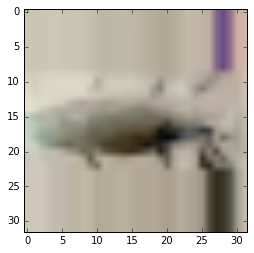

In [878]:
imshow(temp_with_blank)

In [873]:
temp_reduce.shape

(16L, 32L, 3L)

In [874]:
np.max(temp_cnn)

0.99607843137254903

In [875]:
temp_reduced = np.reshape(temp_with_blank , [1, 32, 32, 3])
temp_cnn = reshape_for_cnn(temp_reduced)
temp_cnn /= 255
fish_locations = CNN_model.predict(temp_cnn)

In [876]:
fish_locations

array([[  9.99930382e-01,   2.60149864e-05,   4.22614648e-05,
          1.24573774e-06]], dtype=float32)

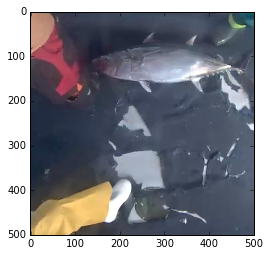

In [771]:
imshow(X_window_list[good_predictions[0][0]])

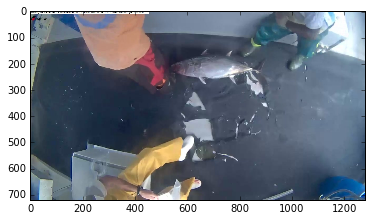

In [730]:
imshow(X[SAMPLE])

# Image pyramid

In [539]:
img = template.T
# generate Gaussian pyramid for A
G = img.copy()
gpA = [G]
for i in xrange(4):
    G = cv2.pyrDown(G)
    gpA.append(G)

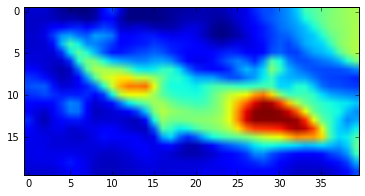

In [540]:
imshow(gpA[3])

# Apply image pyramid images to returned CNN windows

In [544]:
gpA[0].shape

(160L, 320L)

In [632]:
# 0 POS 10 NEG ex 77
img = cv2.cvtColor(X_window_list[good_predictions[0][10]], cv2.COLOR_BGR2GRAY)
template = gpA[1]
template = template.T
img2 = img.copy()

## use normalized result from all images  rather than normalized for one image in order to distinguish maxs and mins more clearly

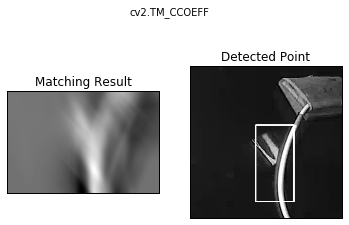

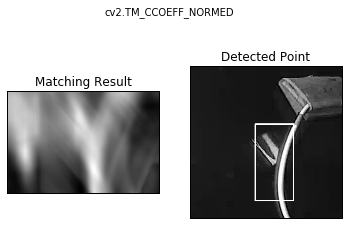

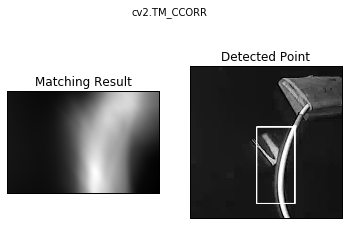

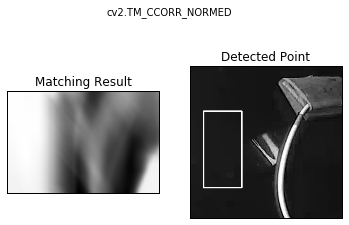

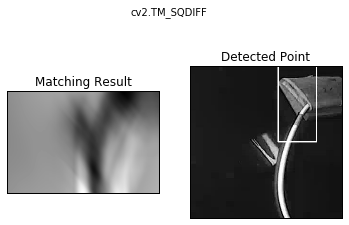

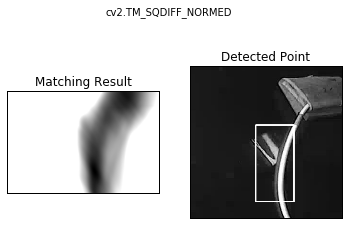

In [633]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#img = cv2.imread('messi5.jpg',0)
#img2 = img.copy()
#template = cv2.imread('template.jpg',0)
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

# Examine combining neg and pos image to compare values

In [673]:
len(good_predictions[0])

9

In [678]:
imag = X_window_list[good_predictions[0][0]]

for i in xrange(5):
    imag = np.append(imag, X_window_list[good_predictions[0][i]], axis=1)

In [675]:
imag.shape

(320L, 3200L, 3L)

In [628]:
img_comb = np.append(X_window_list[good_predictions[0][0]], X_window_list[good_predictions[0][10]], axis =1)

In [629]:
img_comb.shape

(320L, 640L, 3L)

In [679]:
# 0 POS 10 NEG 

img = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)
template = gpA[1]
template = template.T
img2 = img.copy()

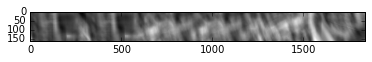

In [686]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#img = cv2.imread('messi5.jpg',0)
#img2 = img.copy()
#template = cv2.imread('template.jpg',0)
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED']#, 'cv2.TM_CCORR',
            #'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.imshow(res, cmap = 'gray')
    #plt.imshow(img, cmap = 'gray')
    #plt.subplot(121),plt.imshow(res,cmap = 'gray')
    #plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    #plt.subplot(122),plt.imshow(img,cmap = 'gray')
    #plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    #plt.suptitle(meth)

    #plt.show()